In [33]:
import requests
import urllib3
import secrets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Strava API Request

In [35]:
auth_url = 'https://www.strava.com/oauth/token'
activities_url = 'https://www.strava.com/api/v3/athlete/activities'

print('Requesting Strava token... \n')
res = requests.post(auth_url, data=secrets.strava_payload, verify=False)
strava_access_token = res.json()['access_token']

header = {'Authorization': 'Bearer ' + strava_access_token}

strava_requests_page_num = 1
all_activities = []

while True:
    strava_param = {'per_page' : 15, 'page' : strava_requests_page_num}
    strava_dataset = requests.get(activities_url, headers=header, params=strava_param).json()

    if len(strava_dataset) == 0:
        print('breaking out of Strava while loop because the response is zero, indicating no more activities.')
        break

    if all_activities:
        print('all activities is populated')
        all_activities.extend(strava_dataset)

    else:
        print('all activities is NOT populated')
        all_activities = strava_dataset

    strava_requests_page_num += 1

print('Total Activities: ', len(all_activities))

Requesting Strava token... 

all activities is NOT populated
all activities is populated
all activities is populated
all activities is populated
breaking out of Strava while loop because the response is zero, indicating no more activities.
Total Activities:  50


## Creating pandas dataframe for running data

In [36]:
run_data = pd.DataFrame(data=all_activities)

In [37]:
run_data.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type',
       'workout_type', 'id', 'start_date', 'start_date_local', 'timezone',
       'utc_offset', 'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'suffer_score', 'average_watts',
       'kilojoules', 'device_watts'],
      dtype='object')

In [38]:
run_data.head()

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,average_watts,kilojoules,device_watts
0,2,"{'id': 8586088, 'resource_state': 1}",PMRP : Hot Afternoon Run,7090.5,2341,2365,210.0,Run,Run,0.0,...,10124522361,0B1C68DC-4E71-4EBB-8217-F688A9582DCD-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
1,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : French Cattle Ranch Approach,1594.6,1483,1483,186.4,Hike,Hike,NaN,...,10023599286,70EA4DF3-F218-4DB7-B818-E242D7EC3F45-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
2,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Approach to Downtown,471.3,625,656,90.8,Hike,Hike,NaN,...,10004892705,7A3018DD-C2AB-447C-AF8E-92D86CE6B16E-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
3,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Morning Run,2927.4,937,943,27.1,Run,Run,0.0,...,9970213520,D9326B4B-A20A-4FFC-963A-A75D2D17971D-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
4,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Morning Run,3801.4,1185,1327,61.0,Run,Run,0.0,...,9970213502,9E9E8812-BB6B-4016-96DA-8E72047B2967-activity.fit,False,2,0,False,NaN,NaN,NaN,NaN


In [39]:
columns_to_drop = ['athlete', 
                   'sport_type', 
                   'workout_type',
                   'location_city',
                   'location_state',
                   'location_country', 
                   'kudos_count', 
                   'comment_count', 
                   'athlete_count', 
                   'photo_count', 
                   'trainer', 
                   'commute', 
                   'manual', 
                   'private',
                   'visibility', 
                   'flagged', 
                   'gear_id', 
                   'has_heartrate', 
                   'heartrate_opt_out', 
                   'display_hide_heartrate_option', 
                   'from_accepted_tag', 
                   'total_photo_count', 
                   'has_kudoed', 
                   'average_watts', 
                   'kilojoules',
                   'achievement_count',
                   'device_watts', 
                   'suffer_score']

run_data.drop(columns=columns_to_drop, inplace=True)

In [40]:
run_data.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'id', 'start_date', 'start_date_local',
       'timezone', 'utc_offset', 'map', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'pr_count'],
      dtype='object')

In [41]:
map_data = pd.json_normalize(run_data['map'])
map_data_info = pd.DataFrame(map_data)
map_data_info

,id,summary_polyline,resource_state
0,a9439898989,inwdFfm}}NBFONWHKEAEQ?QHWb@UBMd@qA`BQZK\GZKPER...,2
1,a9344736492,ifklG~krmSKc@?TCNOFIXIFGZ@NIPKb@MTG^EH?XEt@CHS...,2
2,a9327076219,qailGzmsmSLTADMB@DC?AIGDBDDRIAIDMAL^?DI?CBPv@I...,2
3,a9294421659,sn`lG`~~mSBBIUG_@K[A?OYE?Is@k@qB_@{@Om@Ys@MQOo...,2
4,a9294421645,_w_lGlyanSCMIu@S{@EGB[Ik@AYIIIU@MEEIc@CE?GOQGe...,2
5,a9176575201,ejweFrlr}NIQWOQAAEIAIKE?@FFHOOe@BGEKHSGQ?k@SOO...,2
6,a9159069458,{mwdFhl}}NEXUXo@?[^YPKCQt@eBvBeA|CY^Y|@GCQfAMD...,2
7,a9059541871,unwdFhj}}NACDG?GOa@M??HE@@EC?EHKHEAAFQHO?AACDW...,2
8,a9017048707,kowdFvm}}Nu@VuClDm@bBWTMv@MA[p@QhAOPD\m@r@[tAK...,2
9,a8985168804,}aeeFxop}NFv@AJJRB?C@G^c@b@@VGJDBABFS@?KSG??EK...,2


In [42]:
run_data = pd.concat([run_data, map_data_info], axis=1)
run_data.drop(columns='map', inplace=True)

In [43]:
run_data = run_data.loc[run_data['type'] == 'Run']
run_data

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,id,start_date,start_date_local,...,max_speed,elev_high,elev_low,upload_id,upload_id_str,external_id,pr_count,id,summary_polyline,resource_state
0,2,PMRP : Hot Afternoon Run,7090.5,2341,2365,210.0,Run,9439898989,2023-07-12T20:20:42Z,2023-07-12T16:20:42Z,...,13.532,348.9,259.0,10124522361,10124522361,0B1C68DC-4E71-4EBB-8217-F688A9582DCD-activity.fit,0,a9439898989,inwdFfm}}NBFONWHKEAEQ?QHWb@UBMd@qA`BQZK\GZKPER...,2
3,2,Ten Sleep : Morning Run,2927.4,937,943,27.1,Run,9294421659,2023-06-19T12:34:47Z,2023-06-19T06:34:47Z,...,4.750,1655.9,1583.3,9970213520,9970213520,D9326B4B-A20A-4FFC-963A-A75D2D17971D-activity.fit,0,a9294421659,sn`lG`~~mSBBIUG_@K[A?OYE?Is@k@qB_@{@Om@Ys@MQOo...,2
4,2,Ten Sleep : Morning Run,3801.4,1185,1327,61.0,Run,9294421645,2023-06-17T12:57:06Z,2023-06-17T06:57:06Z,...,6.196,1645.2,1583.4,9970213502,9970213502,9E9E8812-BB6B-4016-96DA-8E72047B2967-activity.fit,2,a9294421645,_w_lGlyanSCMIu@S{@EGB[Ik@AYIIIU@MEEIc@CE?GOQGe...,2
5,2,RRG : Grays Arch Loop w/ Rush Trail,6222.5,2225,2271,173.6,Run,9176575201,2023-05-31T15:42:37Z,2023-05-31T11:42:37Z,...,7.315,392.0,255.0,9845666953,9845666953,5AC4EBC8-8F82-40A1-A71E-464C999BD249-activity.fit,0,a9176575201,ejweFrlr}NIQWOQAAEIAIKE?@FFHOOe@BGEKHSGQ?k@SOO...,2
6,2,PMRP : Rain Run,8973.2,2836,2882,368.6,Run,9159069458,2023-05-28T18:17:37Z,2023-05-28T14:17:37Z,...,16.328,349.9,259.0,9827119565,9827119565,8FDC9AE7-669F-463F-8FE7-69ADAECECDF6-activity.fit,0,a9159069458,{mwdFhl}}NEXUXo@?[^YPKCQt@eBvBeA|CY^Y|@GCQfAMD...,2
7,2,PMRP : Lode Loop and Lode Hill,2615.8,843,849,96.5,Run,9059541871,2023-05-12T19:53:27Z,2023-05-12T15:53:27Z,...,7.168,339.3,267.6,9719069921,9719069921,24A57C94-9908-447D-A155-9BDE2019A7B9-activity.fit,0,a9059541871,unwdFhj}}NACDG?GOa@M??HE@@EC?EHKHEAAFQHO?AACDW...,2
8,2,PMRP : Lode Loop and Flat Holler Loop,9653.3,3349,3385,453.1,Run,9017048707,2023-05-05T18:39:29Z,2023-05-05T14:39:29Z,...,14.712,332.0,259.2,9673999538,9673999538,A1D712A9-AE60-46D6-BC79-079F26074906-activity.fit,1,a9017048707,kowdFvm}}Nu@VuClDm@bBWTMv@MA[p@QhAOPD\m@r@[tAK...,2
10,2,PMRP : Drive By Loop and Lode Loop,5774.7,1769,1827,131.6,Run,8973585450,2023-04-28T18:23:12Z,2023-04-28T14:23:12Z,...,11.087,333.2,258.4,9627942193,9627942193,2F517B9E-B515-40EF-8768-5870F570A507-activity.fit,1,a8973585450,anwdFrk}}N?LQh@?CILa@FWf@IAGJkAbAEN?LCFMDCFORC...,2
12,2,PMRP : Sore Heel Loop,6867.9,2329,2376,228.5,Run,8885448119,2023-04-13T18:21:31Z,2023-04-13T14:21:31Z,...,13.132,333.6,259.0,9534311976,9534311976,89B2BBFD-A972-4F20-97ED-AC0A0EBA02C3-activity.fit,0,a8885448119,oqwdFzn}}NGNQN[h@eAnA?VcAbBKXORk@~Aa@fB_@l@e@z...,2
13,2,RRG : Courthouse Loop,8248.8,3275,3344,279.2,Run,8880411991,2023-04-12T20:59:26Z,2023-04-12T16:59:26Z,...,7.558,398.4,237.7,9528980631,9528980631,3772D582-C7F3-4270-A8B0-64FAC1B02286-activity.fit,0,a8880411991,yvyeFl}v}Ni@GQFAJH`@EZFd@Qr@p@pB\`@CXa@h@uAxA]...,2


## Conversions for Metrics

In [44]:
run_data['distance_miles'] = run_data['distance'] * 0.00062137119
run_data['moving_time_minutes'] = run_data['moving_time'] / 60
run_data['moving_time_hours'] = run_data['moving_time'] / 3600

In [45]:
average_distance_miles = run_data['distance_miles'].mean()
print("Average Distance (miles):", average_distance_miles)

average_time_minutes = run_data['moving_time_minutes'].mean()
print("Average Time Ran (minutes):", average_time_minutes)

max_distance_ran = run_data['distance_miles'].max()
print("Longest Run:", max_distance_ran, "miles")

max_duration_mintues = run_data['moving_time_minutes'].max()
max_duration_hours = run_data['moving_time_hours'].max()
print("Longest Duration:", max_duration_mintues,"minutes. Converted to hours:", max_duration_hours)

total_distance_miles = run_data['distance'].sum() * 0.00062137119
print("Total Distance Covered to the date (miles):", total_distance_miles)

Average Distance (miles): 3.9672101547986474
Average Time Ran (minutes): 40.64313725490196
Longest Run: 9.618018238653 miles
Longest Duration: 117.56666666666666 minutes. Converted to hours: 1.9594444444444445
Total Distance Covered to the date (miles): 134.88514526315402


Text(0, 0.5, 'Moving Time / Minutes')

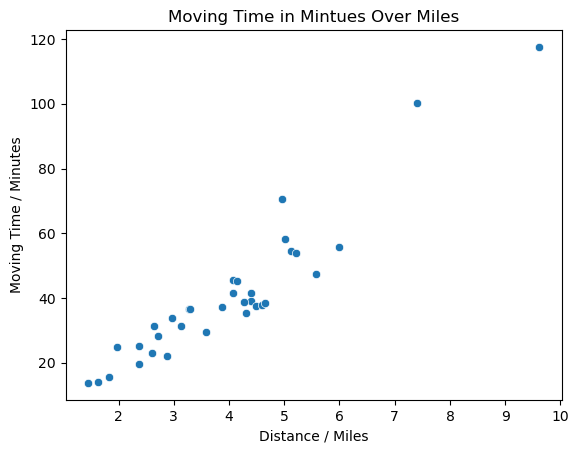

In [46]:
sns.scatterplot(data=run_data,
                x='distance_miles',
                y='moving_time_minutes')

plt.title('Moving Time in Mintues Over Miles')
plt.xlabel('Distance / Miles')
plt.ylabel('Moving Time / Minutes')

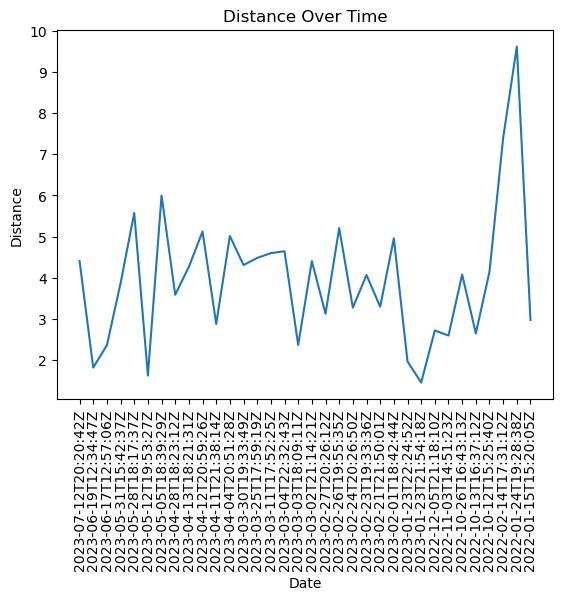

In [47]:
sns.lineplot(data=run_data,
            x= 'start_date',
            y='distance_miles')

plt.title('Distance Over Time')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [48]:
csv_path = 'csv/run_data.csv'
run_data.to_csv(csv_path, index=False)